# Weather Forecasting Using Time Series Analysis

This notebook presents a weather forecasting project focused on predicting daily rainfall in Nalchik city. The approach combines traditional statistical methods (ARIMA) with neural networks (LSTM) to improve prediction accuracy for rainfall events based on historical weather data.

## Key Steps Covered:
- **Data Preprocessing**: Loading and preparing historical weather data for time series analysis
- **ARIMA Modeling**: Building and tuning an ARIMA model to forecast rainfall
- **LSTM Modeling**: Implementing a deep learning approach using LSTM networks for sequence-based prediction
- **Model Evaluation**: Comparing ARIMA and LSTM predictions and evaluating model performance
- **Forecasting**: Generating rainfall predictions for future days

In [1]:
import numpy as np
import random
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Activation, Layer
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# Load the weather data
df = pd.read_csv('/kaggle/input/nalchik-weather/data.csv', delimiter=';', encoding='utf-8', low_memory=False)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['Местное время в Нальчике (аэропорт)'], format="%d.%m.%Y %H:%M")
df = df.sort_values('date')

In [3]:
# Create a binary feature for rainfall
def classify_rain(value):
    """Classify the rain value into binary categories."""
    if pd.isna(value) or value == "Осадков нет":
        return 0
    elif value == "Следы осадков":
        return 1
    else:
        try:
            return 1 if float(value) > 0 else 0
        except ValueError:
            return 0

# Apply the classification function to create the 'rain' column
df['rain'] = df['RRR'].apply(classify_rain)

In [4]:
# Convert the 'date' column to datetime if not already in datetime format
df['date'] = pd.to_datetime(df['date'])

# Create a 'month_year' column
df['month_year'] = df['date'].dt.to_period('M')

# Extract day, month, and year
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Drop duplicates by day
df = df.loc[df.groupby(['year', 'month', 'day'])['rain'].idxmax()]

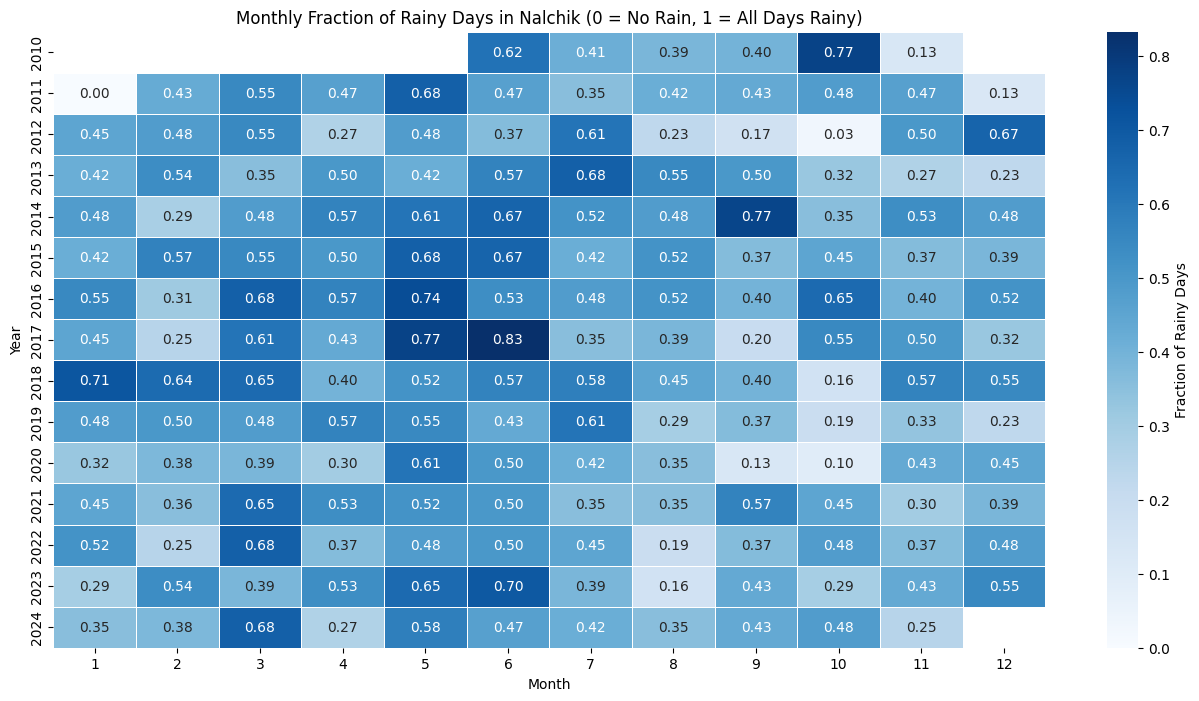

In [5]:
# Calculate the monthly average of rainy days
monthly_rainfall = df.groupby('month_year')['rain'].mean().reset_index()

# Extract year and month separately
monthly_rainfall['year'] = monthly_rainfall['month_year'].dt.year
monthly_rainfall['month'] = monthly_rainfall['month_year'].dt.month

# Pivot the data for heatmap
rain_pivot = monthly_rainfall.pivot(index="year", columns="month", values="rain")

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(rain_pivot, cmap="Blues", cbar_kws={'label': 'Fraction of Rainy Days'}, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Monthly Fraction of Rainy Days in Nalchik (0 = No Rain, 1 = All Days Rainy)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

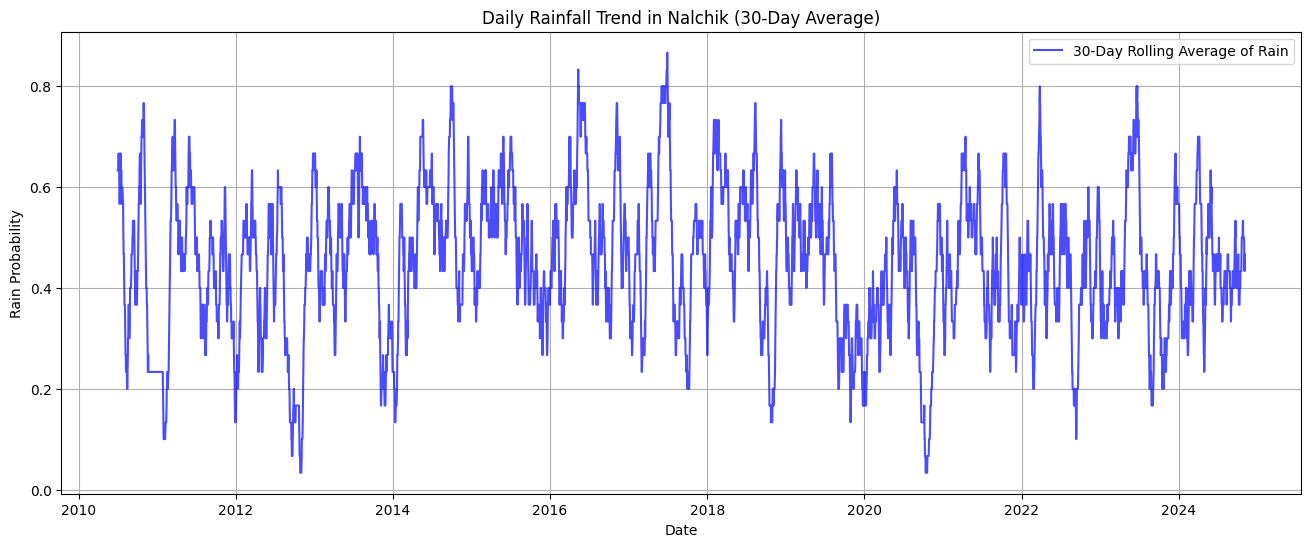

In [6]:
# Optional: Additional line plot for yearly trend
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['rain'].rolling(window=30).mean(), color="blue", alpha=0.7, label='30-Day Rolling Average of Rain')
plt.title('Daily Rainfall Trend in Nalchik (30-Day Average)')
plt.xlabel('Date')
plt.ylabel('Rain Probability')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Keep only necessary columns
df = df[['date', 'day', 'month', 'year', 'rain']]
df = df.set_index('date')

# Reset year to start from 2010 (for better feature scaling)
df.year = df.year - 2010

# Display the processed DataFrame
print(df.head())

                     day  month  year  rain
date                                       
2010-06-01 06:00:00    1      6     0     0
2010-06-02 00:00:00    2      6     0     0
2010-06-03 06:00:00    3      6     0     1
2010-06-04 00:00:00    4      6     0     0
2010-06-05 21:00:00    5      6     0     1


In [8]:
# Drop date index
df = df.reset_index(drop=True)
df.tail()

,day,month,year,rain
5200,31,10,14,0
5201,1,11,14,0
5202,2,11,14,0
5203,3,11,14,1
5204,4,11,14,0


In [9]:
# Split the data for training and testing ARIMA model
train_size = int(len(df) * 0.95)
train, test = df['rain'][:train_size], df['rain'][train_size:]

In [10]:
# Train the ARIMA model
arima_model = ARIMA(train, order=(2, 0, 2))  # Adjust order if needed
arima_model_fit = arima_model.fit()

In [11]:
# Forecast and evaluate the ARIMA model
arima_pred = arima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
arima_pred_binary = np.where(arima_pred > 0.5, 1, 0)
print("ARIMA Accuracy:", accuracy_score(test, arima_pred_binary))

ARIMA Accuracy: 0.5440613026819924


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [12]:
# Preparing data for LSTM model
train_size = int(len(df) * 0.95)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [13]:
# Select features for LSTM
features = ['day', 'month', 'year', 'rain']

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Function to create sequences for LSTM
def create_sequences(data, seq_length=5):
    """Create sequences of features for LSTM."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # Include all features in the sequence
        y.append(data[i+seq_length, -1])   # Target is 'rain' (last feature in scaled data)
    return np.array(X), np.array(y)

# Create sequences for training and testing
seq_length = 20
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [14]:
# Define custom activation functions
class OptimA(Layer):  # Optimal Activation - https://github.com/EmotionEngineer/OptimA
    def __init__(self, **kwargs):
        super(OptimA, self).__init__(**kwargs)

    def build(self, input_shape):
        # Defining trainable parameters
        self.alpha = self.add_weight(name='alpha', shape=(), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(), initializer=tf.keras.initializers.Constant(0.5), trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(), initializer='ones', trainable=True)
        self.delta = self.add_weight(name='delta', shape=(), initializer=tf.keras.initializers.Constant(0.5), trainable=True)
        self.lambda_ = self.add_weight(name='lambda', shape=(), initializer='ones', trainable=True)

    def call(self, x):
        term1 = self.alpha * tf.math.tanh(self.beta * x)
        term2 = self.gamma * tf.math.softplus(self.delta * x) * tf.math.sigmoid(self.lambda_ * x)
        return term1 + term2

In [15]:
# Calculate class weights for handling imbalanced classes
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Define the LSTM model architecture
model_lstm = Sequential([
    LSTM(64, input_shape=(seq_length, len(features)), activation=OptimA()),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model_lstm.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.95, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

# Set up Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the weights of the best model
    verbose=1               # Verbose output for debugging
)

# Train the LSTM model with class weights and Early Stopping
model_lstm.fit(X_train, y_train, epochs=1000, batch_size=1024, 
                validation_data=(X_test, y_test), 
                class_weight=class_weights, 
                callbacks=[early_stopping])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000


I0000 00:00:1730837732.247140      69 service.cc:145] XLA service 0x56544f179c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730837732.247187      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/5 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.4492 - loss: 0.8160

I0000 00:00:1730837734.030211      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.4588 - loss: 0.7584 - val_accuracy: 0.5353 - val_loss: 0.6984
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5507 - loss: 0.7114 - val_accuracy: 0.5353 - val_loss: 0.6860
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5498 - loss: 0.6869 - val_accuracy: 0.4647 - val_loss: 0.7035
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4493 - loss: 0.6936 - val_accuracy: 0.4647 - val_loss: 0.7078
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4493 - loss: 0.6927 - val_accuracy: 0.4647 - val_loss: 0.6942
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5131 - loss: 0.6842 - val_accuracy: 0.6058 - val_loss: 0.6842
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6138 - loss: 0.6814 - val_accuracy: 0.5602 - val_loss: 0.6816
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5524 - loss: 0.6814 - val_accuracy: 0.5809 - val_loss: 0.6

In [16]:
# Make predictions with the LSTM model
predictions = model_lstm.predict(X_test)
forecast_lstm = (predictions > 0.5).astype(int).flatten()  # Threshold to classify as 0 or 1

# Evaluate the LSTM model accuracy
accuracy_lstm = accuracy_score(y_test, forecast_lstm)
print("LSTM Model Accuracy with Additional Features:", accuracy_lstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
LSTM Model Accuracy with Additional Features: 0.6473029045643154


In [17]:
# Forecast the next day after the test set
next_day_pred_arima = arima_model_fit.predict(start=len(train) + len(test), end=len(train) + len(test), typ='levels').iloc[0]
next_day_pred_binary_arima = 1 if next_day_pred_arima > 0.5 else 0
print("Next day ARIMA prediction (0 = No Rain, 1 = Rain):", next_day_pred_binary_arima)

Next day ARIMA prediction (0 = No Rain, 1 = Rain): 0


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [18]:
# Get the last sequence from the test set for prediction
last_sequence = test_scaled[-seq_length:]  # Extract last 'seq_length' data points
last_sequence = np.expand_dims(last_sequence, axis=0)  # Reshape to match model input shape

# Predict the next day using LSTM
next_day_pred_lstm = model_lstm.predict(last_sequence)
next_day_pred_binary_lstm = 1 if next_day_pred_lstm > 0.5 else 0
print("Next day LSTM prediction (0 = No Rain, 1 = Rain):", next_day_pred_binary_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Next day LSTM prediction (0 = No Rain, 1 = Rain): 0
